In [1]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import xgboost as xgb

# Download the dataset
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

/home/nicolas/miniconda3/envs/madkudu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/nicolas/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


## 1. Data Preprocessing

In [2]:
import pandas as pd
df = pd.read_csv(path + "/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Data Exploration (Structure, Data types, Summary statistics)

In [3]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

In [4]:
df = df.drop(["customerID"], axis=1) # Dropping customerID as it is not useful for the model

# Based on the dataset, columns with numerical values should be [tenure, MonthlyCharges, TotalCharges]
numerical_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce") # Converting columns to numeric

display(df.head())
display(df[numerical_cols].describe())

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


### Handling missing values

In [5]:
print(df.isnull().sum())

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [6]:
# There are 11 missing values in TotalCharges column. We can replace them with the median value of the column.
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

### Categorical Variables Encoding

In [7]:
preprocessed_df = df.copy()

# Replacing categorical values with numerical values

preprocessed_df['gender'] = preprocessed_df['gender'].map({"Female": 0, "Male": 1})
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    preprocessed_df[col] = preprocessed_df[col].map({'Yes': 1, 'No': 0})

preprocessed_df = pd.get_dummies(preprocessed_df, columns=['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'], drop_first=True, dtype=int)
display(preprocessed_df.head())

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,0,0,0,0,0,0,0,0,1,0


In [8]:
print(preprocessed_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7043 non-null   int64  
 1   SeniorCitizen                          7043 non-null   int64  
 2   Partner                                7043 non-null   int64  
 3   Dependents                             7043 non-null   int64  
 4   tenure                                 7043 non-null   int64  
 5   PhoneService                           7043 non-null   int64  
 6   PaperlessBilling                       7043 non-null   int64  
 7   MonthlyCharges                         7043 non-null   float64
 8   TotalCharges                           7043 non-null   float64
 9   Churn                                  7043 non-null   int64  
 10  MultipleLines_No phone service         7043 non-null   int64  
 11  Mult

### Scaling Numerical Values

In [21]:
# Scaling the numerical columns
scaler = StandardScaler()
scaled_df = preprocessed_df.copy()

for col in numerical_cols:
    scaled_df[col] = scaler.fit_transform(scaled_df[[col]])

final_df = scaled_df.copy()
final_df.to_csv("preprocessed_data.csv", index=False)
final_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,-1.277445,0,1,-1.160323,-0.994242,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0.066327,1,0,-0.259629,-0.173244,0,...,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,-1.236724,1,1,-0.362660,-0.959674,1,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0.514251,0,0,-0.746535,-0.194766,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,-1.236724,1,1,0.197365,-0.940470,1,...,0,0,0,0,0,0,0,0,1,0


## 2. Model devlopment

In [22]:
X = final_df.drop('Churn', axis=1)
y = final_df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
def train_and_evaluate_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return model

### Logistic Regression


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409

Cross validation scores: [0.80411639 0.81121363 0.79063165 0.81107955 0.80397727]
Mean cross validation score: 0.8042036986257177
AUC-ROC score: 0.7496998147132194


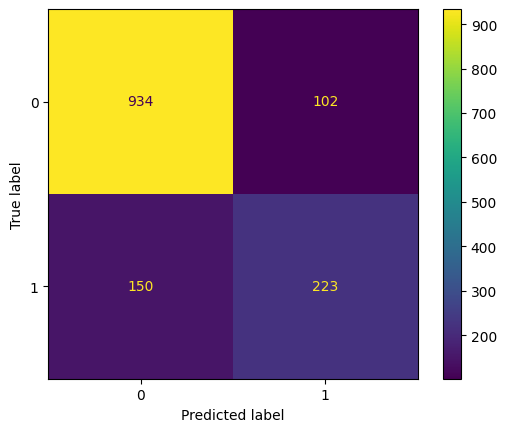

In [12]:
model = LogisticRegression()
model = train_and_evaluate_model(X_train, X_test, y_train, y_test, model)

y_pred = model.predict(X_test)

# Cross validation
scores = cross_val_score(model, X, y, cv=5)
print("Cross validation scores:", scores)
print("Mean cross validation score:", scores.mean())

# Using AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred)
print("AUC-ROC score:", roc_auc)


Best parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.8020950321591297
Test set score: 0.8197303051809794
AUC-ROC score 0.7470188495657665

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.59      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.81      0.82      0.82      1409



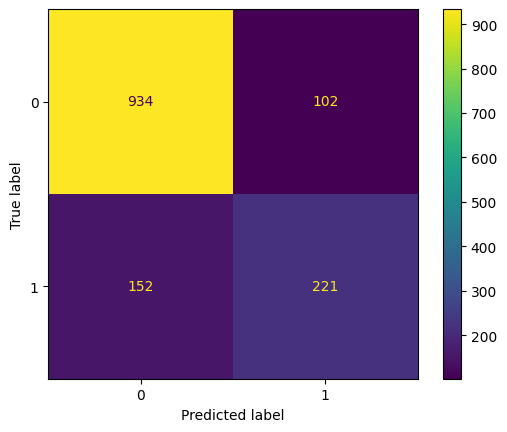

In [13]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'], 
    'solver': ['lbfgs', 'liblinear']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print("Test set score:", grid_search.score(X_test, y_test))
print("AUC-ROC score", roc_auc_score(y_test, grid_search.predict(X_test)))

model = LogisticRegression(**grid_search.best_params_)
model = train_and_evaluate_model(X_train, X_test, y_train, y_test, model)

### KNeighbors


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1036
           1       0.64      0.39      0.49       373

    accuracy                           0.78      1409
   macro avg       0.72      0.66      0.67      1409
weighted avg       0.76      0.78      0.76      1409



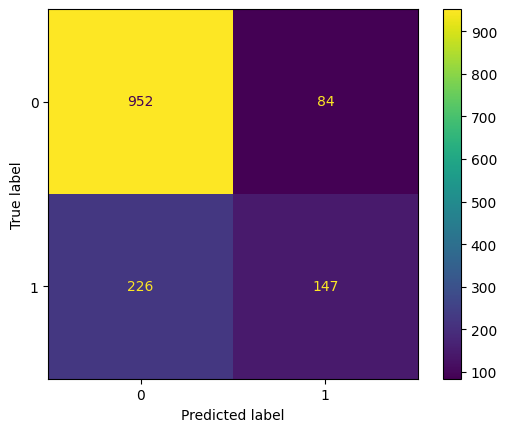

In [14]:
model = KNeighborsClassifier(n_neighbors=4)
model = train_and_evaluate_model(X_train, X_test, y_train, y_test, model)

Best parameters: {'metric': 'manhattan', 'n_neighbors': np.int64(18), 'weights': 'uniform'}
Best cross-validation score: 0.7926889004115045
Test set score: 0.8076650106458482
AUC-ROC score 0.7225149316302131

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1036
           1       0.67      0.54      0.60       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



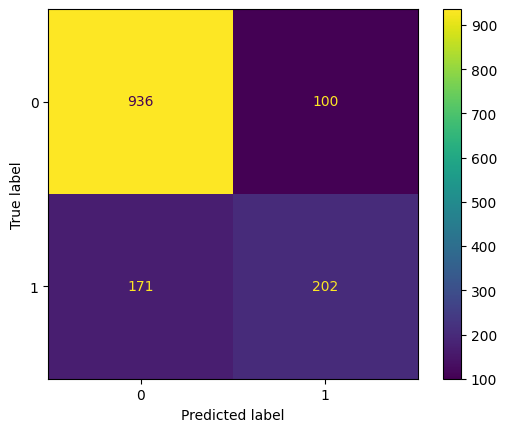

In [15]:
# Grid search for hyperparameter tuning

param_grid = { 
    'n_neighbors': np.arange(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print("Test set score:", grid_search.score(X_test, y_test))
print("AUC-ROC score", roc_auc_score(y_test, grid_search.predict(X_test)))


model = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], weights=grid_search.best_params_['weights'], metric=grid_search.best_params_['metric'])
model = train_and_evaluate_model(X_train, X_test, y_train, y_test, model)


### Random Forest


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.87      1036
           1       0.65      0.46      0.54       373

    accuracy                           0.79      1409
   macro avg       0.74      0.68      0.70      1409
weighted avg       0.78      0.79      0.78      1409



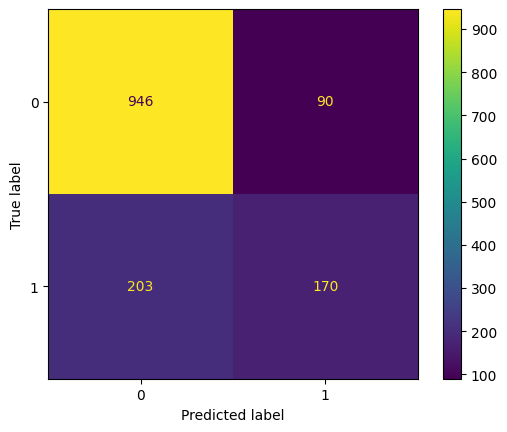

In [16]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model = train_and_evaluate_model(X_train, X_test, y_train, y_test, model)

/home/nicolas/miniconda3/envs/madkudu/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.8052882501367215
Test set score: 0.8097941802696949
AUC-ROC score 0.7136685229848768

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.87      1036
           1       0.68      0.50      0.58       373

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409



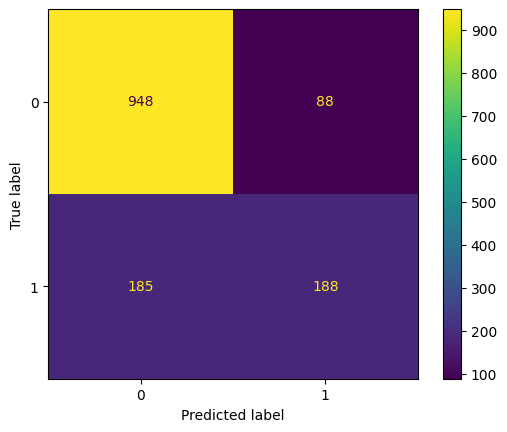

In [17]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print("Test set score:", grid_search.score(X_test, y_test))
print("AUC-ROC score", roc_auc_score(y_test, grid_search.predict(X_test)))

model = RandomForestClassifier(**grid_search.best_params_)
model = train_and_evaluate_model(X_train, X_test, y_train, y_test, model)


### Neural Network

Epoch 0, Loss: 0.9348100618030248
Epoch 10, Loss: 0.9085054672166203
Epoch 20, Loss: 0.8999583881892516
Epoch 30, Loss: 0.8933689192439733
Epoch 40, Loss: 0.8895155399033193
Epoch 50, Loss: 0.8836978935123829
Epoch 60, Loss: 0.8811845143189591
Epoch 70, Loss: 0.8788104646661309
Early stopping triggered

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1036
           1       0.63      0.65      0.64       373

    accuracy                           0.81      1409
   macro avg       0.75      0.75      0.75      1409
weighted avg       0.81      0.81      0.81      1409

AUC-ROC score: 0.8506888734770773


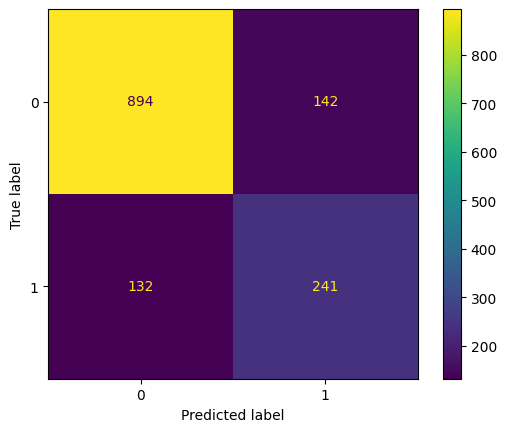

In [18]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

input_dim = X_train.shape[1]
hidden_dim = 32
output_dim = 1

model = NeuralNetwork(input_dim, hidden_dim, output_dim)
pos_weight = torch.tensor([len(y_train[y_train == 0]) / len(y_train[y_train == 1])], dtype=torch.float32)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

best_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(1000):
    model.train()
    epoch_loss = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss}")

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor).numpy()
    y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("AUC-ROC score:", roc_auc)


### XGBoost

[0]	train-auc:0.85001	test-auc:0.83997
[10]	train-auc:0.87805	test-auc:0.85796
[20]	train-auc:0.88602	test-auc:0.85903
[30]	train-auc:0.89448	test-auc:0.85833
[31]	train-auc:0.89576	test-auc:0.85841


/home/nicolas/miniconda3/envs/madkudu/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [02:20:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      1036
           1       0.54      0.82      0.65       373

    accuracy                           0.77      1409
   macro avg       0.73      0.78      0.74      1409
weighted avg       0.82      0.77      0.78      1409

AUC-ROC score: 0.858020122765431


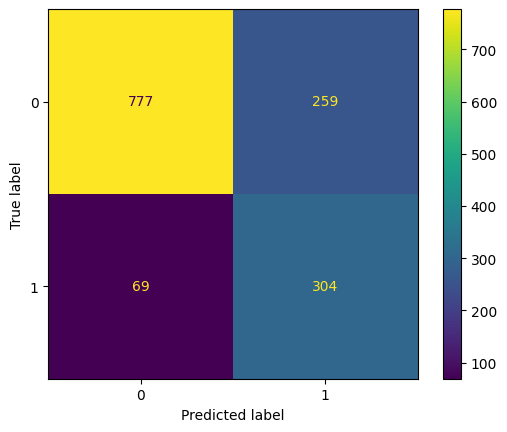

In [19]:
negative_class = len(y_train[y_train == 0])
positive_class = len(y_train[y_train == 1])
scale_pos_weight = negative_class / positive_class

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'scale_pos_weight': scale_pos_weight,
    'eval_metric': 'auc',
    'max_depth': 6,         # Depth of the trees
    'learning_rate': 0.1,   # Step size shrinkage
    'n_estimators': 100,    # Number of boosting rounds
    'subsample': 0.8,       # Randomly sample training data
    'colsample_bytree': 0.8 # Randomly sample features for each tree
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=10,
    verbose_eval=10
)


y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# AUC-ROC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("AUC-ROC score:", roc_auc)


In [24]:
model.save_model('xgboost_model.json')

# Save data with predictions
data = pd.read_csv("preprocessed_data.csv")

def predict_churn(row):
    data = pd.DataFrame([row])
    dtest = xgb.DMatrix(data.drop(['Churn'], axis=1))
    
    churn_probability = model.predict(dtest)[0]
    churn_label = "Churn" if churn_probability > 0.5 else "No Churn"
    
    return churn_probability, churn_label

data['ChurnProbability'], data['ChurnPrediction'] = zip(*data.apply(predict_churn, axis=1))
data.to_csv("churn_predictions.csv", index=False)
